Experimenting with bunch of differnet settings in ANN

In [16]:
import csv

with open('./lichess/data_1/bitboard_8.csv', 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        # Process your CSV data here
        print(row)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '1.0', '0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'

In [2]:
import os
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import chess

In [3]:
csvs = []
for csv in os.listdir("./lichess/data_1"):
    csvs.append(csv)
len(csvs)

57

In [4]:
def prepare_data(df, batch_size):
    targets_numpy = df.result.values
    features_numpy = df.loc[:,df.columns != "result"].values

    features_train, features_test, targets_train, targets_test = train_test_split(
        features_numpy,
        targets_numpy,
        test_size = 0.2,
        random_state = random.randint(0,100)
    )

    featuresTrain = torch.from_numpy(features_train).type(torch.float32)
    targetsTrain = torch.from_numpy(targets_train).type(torch.float32)

    featuresTest = torch.from_numpy(features_test).type(torch.float32)
    targetsTest = torch.from_numpy(targets_test).type(torch.float32)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
    test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

    # data loader
    train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test, batch_size = batch_size, shuffle = True)

    return train_loader, test_loader

In [5]:
def threshold_tensor(x, threshold=0.5):
    thresholded_x = (x >= threshold).float()
    return thresholded_x

In [6]:
class ANNModel1(nn.Module):
    def __init__(self, input_dim, hidden_dim_0, output_dim):
        super(ANNModel1, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_0)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim_0, output_dim)

        self.sig1 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)

        x = self.sig1(x)

        return x

In [60]:
# ANN1 Learning rate finder
error = nn.MSELoss()
learning_rate = 1e-6
input_dim = 1088
hidden_dim_0 = 512
output_dim = 1
batch_size = 128
lr_find_range = (-6, 0)

train_index = random.randint(0,56)
print(f"TRAIN_INDEX: {train_index}")
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

lr_dict = {}
loss_dict = {}

optimizer_dict = {
    "Adadelta": torch.optim.Adadelta,
    "Adagrad": torch.optim.Adagrad,
    "Adam": torch.optim.Adam,
    "Adamax": torch.optim.Adamax,
    "ASGD": torch.optim.ASGD,
    "NAdam": torch.optim.NAdam,
    "RAdam": torch.optim.RAdam,
    "RMSprop": torch.optim.RMSprop,
    "SGD": torch.optim.SGD,
    "SGD-Momentum": torch.optim.SGD,
}

for algo_name, optimizer_class in optimizer_dict.items():
    print(algo_name)
    model = ANNModel1(input_dim, hidden_dim_0, output_dim)
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum = 0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_list = []
    lr_list = []
    
    min_loss = float('inf')
    epoch_count = 0

    for lr in tqdm(torch.logspace(lr_find_range[0], lr_find_range[1], steps=100)):
        optimizer.param_groups[0]['lr'] = lr
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        temp_loss = np.mean(temp_loss_list)
        loss_list.append(temp_loss)
        lr_list.append(lr.item())
    lr_dict[algo_name] = loss_list

TRAIN_INDEX: 4
Adadelta


100%|██████████| 100/100 [08:53<00:00,  5.34s/it]


Adagrad


100%|██████████| 100/100 [06:47<00:00,  4.08s/it]


Adam


100%|██████████| 100/100 [08:43<00:00,  5.23s/it]


Adamax


100%|██████████| 100/100 [09:47<00:00,  5.88s/it]


ASGD


  0%|          | 0/100 [00:00<?, ?it/s]/Users/horatio/anaconda3/envs/seminar_chess/lib/python3.11/site-packages/torch/optim/asgd.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state["eta"] = torch.tensor(group["lr"])
100%|██████████| 100/100 [06:24<00:00,  3.84s/it]


NAdam


100%|██████████| 100/100 [09:30<00:00,  5.70s/it]


RAdam


100%|██████████| 100/100 [12:38<00:00,  7.59s/it]


RMSprop


100%|██████████| 100/100 [08:41<00:00,  5.22s/it]


Rprop


100%|██████████| 100/100 [13:39<00:00,  8.19s/it]


SGD


100%|██████████| 100/100 [07:25<00:00,  4.46s/it]


SGD-Momentum


100%|██████████| 100/100 [08:23<00:00,  5.03s/it]


In [61]:
df = pd.DataFrame(lr_dict)
df['LR'] = lr_list
df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum,LR
0,0.234946,0.234751,0.234479,0.234849,0.234517,0.234485,0.235067,0.234315,0.234577,0.234834,0.235162,1.000000e-06
1,0.234945,0.234699,0.233912,0.234514,0.234517,0.233840,0.234705,0.233856,0.233766,0.234833,0.235152,1.149757e-06
2,0.234945,0.234664,0.233421,0.234258,0.234516,0.233380,0.234293,0.233378,0.233115,0.234832,0.235140,1.321941e-06
3,0.234945,0.234635,0.232880,0.234025,0.234516,0.232865,0.233814,0.232848,0.232487,0.234830,0.235127,1.519911e-06
4,0.234944,0.234609,0.232273,0.233794,0.234516,0.232279,0.233261,0.232257,0.231922,0.234829,0.235112,1.747528e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.104093,0.046676,0.477687,0.415866,0.123173,0.475184,0.490094,0.478049,0.195494,0.111472,0.115573,5.722368e-01
96,0.100281,0.047241,0.477687,0.431748,0.119892,0.475184,0.490094,0.478049,0.195245,0.107848,0.119416,6.579332e-01
97,0.097173,0.047461,0.477687,0.433884,0.115089,0.475184,0.490094,0.478049,0.195019,0.104566,0.132037,7.564633e-01
98,0.094809,0.045765,0.477687,0.448897,0.112052,0.475184,0.490094,0.478049,0.194764,0.102208,0.145508,8.697490e-01


In [62]:
df.to_csv('./model_histories/lichess_learning_rate_hd_1.csv', index = False)

In [63]:
df = pd.read_csv("./model_histories/lichess_learning_rate_hd_1.csv")
df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum,LR
0,0.234946,0.234751,0.234479,0.234849,0.234517,0.234485,0.235067,0.234315,0.234577,0.234834,0.235162,1.000000e-06
1,0.234945,0.234699,0.233912,0.234514,0.234517,0.233840,0.234705,0.233856,0.233766,0.234833,0.235152,1.149757e-06
2,0.234945,0.234664,0.233421,0.234258,0.234516,0.233380,0.234293,0.233378,0.233115,0.234832,0.235140,1.321941e-06
3,0.234945,0.234635,0.232880,0.234025,0.234516,0.232865,0.233814,0.232848,0.232487,0.234830,0.235127,1.519911e-06
4,0.234944,0.234609,0.232273,0.233794,0.234516,0.232279,0.233261,0.232257,0.231922,0.234829,0.235112,1.747528e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.104093,0.046676,0.477687,0.415866,0.123173,0.475184,0.490094,0.478049,0.195494,0.111472,0.115573,5.722368e-01
96,0.100281,0.047241,0.477687,0.431748,0.119892,0.475184,0.490094,0.478049,0.195245,0.107848,0.119416,6.579332e-01
97,0.097173,0.047461,0.477687,0.433884,0.115089,0.475184,0.490094,0.478049,0.195019,0.104566,0.132037,7.564633e-01
98,0.094809,0.045765,0.477687,0.448897,0.112052,0.475184,0.490094,0.478049,0.194764,0.102208,0.145508,8.697490e-01


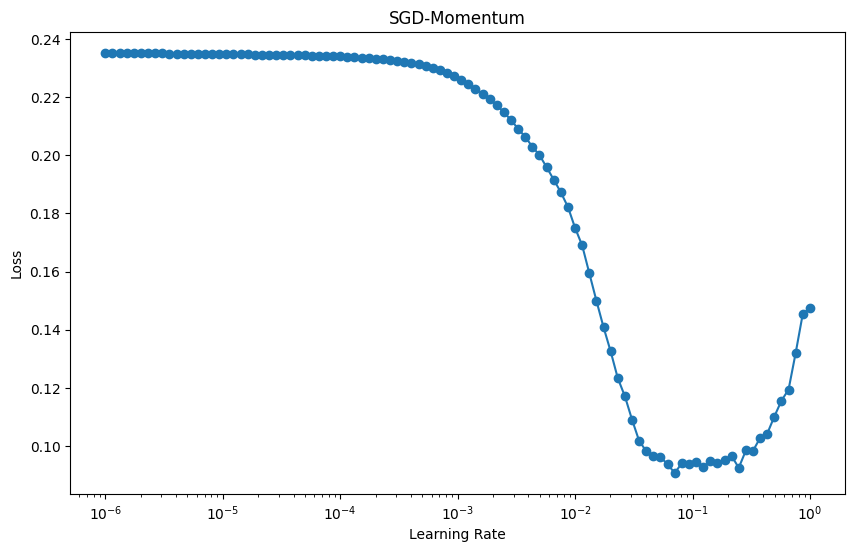

In [74]:
idx = 10
keys = list(df.columns)
plt.figure(figsize=(10, 6))
plt.title(keys[idx])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.plot(df['LR'], df[keys[idx]], marker='o')
plt.show()

In [14]:
# ANN1
error = nn.MSELoss()
input_dim = 1088
hidden_dim_0 = 512
output_dim = 1
batch_size = 128
train_index = 4
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

train_loss_dict = {}
val_loss_dict = {}

optimizer_dict = {
    "Adadelta": (torch.optim.Adadelta, 0.1),
    "Adagrad": (torch.optim.Adagrad, 0.01),
    "Adam": (torch.optim.Adam, 1e-4),
    "Adamax": (torch.optim.Adamax, 1e-4),
    "ASGD": (torch.optim.ASGD, 0.1),
    "NAdam": (torch.optim.NAdam, 1e-4),
    "RAdam": (torch.optim.RAdam, 1e-4),
    "RMSprop": (torch.optim.RMSprop, 1e-4),
    "SGD": (torch.optim.SGD, 0.1),
    "SGD-Momentum": (torch.optim.SGD, 0.01),
}

for algo_name, optimizer_tuple in optimizer_dict.items():
    print(algo_name)
    optimizer_class = optimizer_tuple[0]
    learning_rate = optimizer_tuple[1]
    model = ANNModel1(input_dim, hidden_dim_0, output_dim)
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum = 0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    train_loss_list = []
    val_loss_list = []
    min_loss = float('inf')
    epoch_count = 0

    while True:
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        train_loss = np.mean(temp_loss_list)
        train_loss_list.append(train_loss)
        temp_loss_list = []

        for boards, labels in test_loader:
            test = boards.view(-1, 1088)
            outputs = model(test)
            temp_loss_list.append(error(outputs, labels.view(-1, 1)).detach().item())
        
        val_loss = np.mean(temp_loss_list)
        val_loss_list.append(val_loss)

        print(f"TRAIN_LOSS: {round(float(train_loss), 4)}, VAL:_LOSS: {round(float(val_loss), 4)}")

        if val_loss < min_loss:
            min_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1

        if epoch_count >= 10:
            print(f"MIN_TRAIN_LOSS: {min(train_loss_list)}")
            print(f"MIN_VAL_LOSS: {min(val_loss_list)}")
            break
            
    train_loss_dict[algo_name] = train_loss_list
    val_loss_dict[algo_name] = val_loss_list

Adadelta
TRAIN_LOSS: 0.2306, VAL:_LOSS: 0.2267
TRAIN_LOSS: 0.2219, VAL:_LOSS: 0.2193
TRAIN_LOSS: 0.2146, VAL:_LOSS: 0.2125
TRAIN_LOSS: 0.2079, VAL:_LOSS: 0.2052
TRAIN_LOSS: 0.2019, VAL:_LOSS: 0.1999
TRAIN_LOSS: 0.1959, VAL:_LOSS: 0.1934
TRAIN_LOSS: 0.1902, VAL:_LOSS: 0.1885
TRAIN_LOSS: 0.1841, VAL:_LOSS: 0.1827
TRAIN_LOSS: 0.1777, VAL:_LOSS: 0.1777
TRAIN_LOSS: 0.1709, VAL:_LOSS: 0.1706
TRAIN_LOSS: 0.1636, VAL:_LOSS: 0.1613
TRAIN_LOSS: 0.1567, VAL:_LOSS: 0.158
TRAIN_LOSS: 0.1495, VAL:_LOSS: 0.1491
TRAIN_LOSS: 0.1428, VAL:_LOSS: 0.143
TRAIN_LOSS: 0.1368, VAL:_LOSS: 0.1357
TRAIN_LOSS: 0.1299, VAL:_LOSS: 0.1351
TRAIN_LOSS: 0.1246, VAL:_LOSS: 0.1257
TRAIN_LOSS: 0.119, VAL:_LOSS: 0.1287
TRAIN_LOSS: 0.114, VAL:_LOSS: 0.1149
TRAIN_LOSS: 0.1093, VAL:_LOSS: 0.1155
TRAIN_LOSS: 0.1047, VAL:_LOSS: 0.1141
TRAIN_LOSS: 0.1005, VAL:_LOSS: 0.1023
TRAIN_LOSS: 0.0962, VAL:_LOSS: 0.105
TRAIN_LOSS: 0.0929, VAL:_LOSS: 0.1003
TRAIN_LOSS: 0.0891, VAL:_LOSS: 0.1016
TRAIN_LOSS: 0.0863, VAL:_LOSS: 0.0935
TRAIN_LO

TRAIN_LOSS: 0.0152, VAL:_LOSS: 0.0312
TRAIN_LOSS: 0.015, VAL:_LOSS: 0.0319
TRAIN_LOSS: 0.0149, VAL:_LOSS: 0.031
TRAIN_LOSS: 0.0147, VAL:_LOSS: 0.0314
TRAIN_LOSS: 0.0146, VAL:_LOSS: 0.0312
TRAIN_LOSS: 0.0145, VAL:_LOSS: 0.0307
TRAIN_LOSS: 0.0143, VAL:_LOSS: 0.0306
TRAIN_LOSS: 0.0142, VAL:_LOSS: 0.0304
TRAIN_LOSS: 0.0141, VAL:_LOSS: 0.0305
TRAIN_LOSS: 0.0139, VAL:_LOSS: 0.0303
TRAIN_LOSS: 0.0138, VAL:_LOSS: 0.0304
TRAIN_LOSS: 0.0136, VAL:_LOSS: 0.0301
TRAIN_LOSS: 0.0135, VAL:_LOSS: 0.0298
TRAIN_LOSS: 0.0134, VAL:_LOSS: 0.0298
TRAIN_LOSS: 0.0132, VAL:_LOSS: 0.0299
TRAIN_LOSS: 0.0132, VAL:_LOSS: 0.0299
TRAIN_LOSS: 0.013, VAL:_LOSS: 0.0296
TRAIN_LOSS: 0.013, VAL:_LOSS: 0.0294
TRAIN_LOSS: 0.0128, VAL:_LOSS: 0.0294
TRAIN_LOSS: 0.0127, VAL:_LOSS: 0.0296
TRAIN_LOSS: 0.0126, VAL:_LOSS: 0.0292
TRAIN_LOSS: 0.0125, VAL:_LOSS: 0.0291
TRAIN_LOSS: 0.0124, VAL:_LOSS: 0.0294
TRAIN_LOSS: 0.0123, VAL:_LOSS: 0.0294
TRAIN_LOSS: 0.0122, VAL:_LOSS: 0.0288
TRAIN_LOSS: 0.0121, VAL:_LOSS: 0.0289
TRAIN_LOSS: 0.01

KeyboardInterrupt: 

In [ ]:
val_loss_ranking_list = [np.mean(val_loss_dict[x][-10:]) for x in val_loss_dict]
val_loss_ranking_dict = dict(zip(list(val_loss_dict.keys()), val_loss_ranking_list))
val_loss_ranking_dict = sorted(val_loss_ranking_dict.items(), key=lambda x: x[1])
val_loss_ranking_dict

In [ ]:
max_len = max(len(lst) for lst in val_loss_dict.values())
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in val_loss_dict.items()}
loss_df = pd.DataFrame(loss_filled_results)
loss_df.to_csv("./model_histories/ANN/optimizer_selector_val_loss_hd_1.csv", index = False)
loss_df

In [ ]:
loss_df = pd.read_csv('./model_histories/ANN/optimizer_selector_val_loss_hd_1.csv"')
loss_df

In [ ]:
class ANNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim_0, hidden_dim_1 output_dim):
        super(ANNModel2, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_0)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim_0, hidden_dim_1)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

        self.sig1 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)

        x = self.sig1(x)

        return x

In [ ]:
# ANN2 Learning rate finder
error = nn.MSELoss()
learning_rate = 1e-6
input_dim = 1088
hidden_dim_0 = 512
hidden_dim_1 = 512
output_dim = 1
batch_size = 128
lr_find_range = (-6, 0)

train_index = random.randint(0,56)
print(f"TRAIN_INDEX: {train_index}")
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

lr_dict = {}
loss_dict = {}

optimizer_dict = {
    "Adadelta": torch.optim.Adadelta,
    "Adagrad": torch.optim.Adagrad,
    "Adam": torch.optim.Adam,
    "Adamax": torch.optim.Adamax,
    "ASGD": torch.optim.ASGD,
    "NAdam": torch.optim.NAdam,
    "RAdam": torch.optim.RAdam,
    "RMSprop": torch.optim.RMSprop,
    "SGD": torch.optim.SGD,
    "SGD-Momentum": torch.optim.SGD,
}

for algo_name, optimizer_class in optimizer_dict.items():
    print(algo_name)
    model = ANNModel2(input_dim, hidden_dim_0, hidden_dim_1, output_dim)
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum = 0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_list = []
    lr_list = []
    
    min_loss = float('inf')
    epoch_count = 0

    for lr in tqdm(torch.logspace(lr_find_range[0], lr_find_range[1], steps=100)):
        optimizer.param_groups[0]['lr'] = lr
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        temp_loss = np.mean(temp_loss_list)
        loss_list.append(temp_loss)
        lr_list.append(lr.item())
    lr_dict[algo_name] = loss_list

In [ ]:
df = pd.DataFrame(lr_dict)
df['LR'] = lr_list
df.to_csv('./model_histories/lichess_learning_rate_hd_2.csv', index = False)

In [ ]:
df = pd.read_csv("./model_histories/lichess_learning_rate_hd_2.csv")
df

In [ ]:
idx = 0
keys = list(df.columns)
plt.figure(figsize=(10, 6))
plt.title(keys[idx])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.plot(df['LR'], df[keys[idx]], marker='o')
plt.show()

In [30]:
# ANN2
error = nn.MSELoss()
input_dim = 1088
hidden_dim_0 = 512
hidden_dim_0 = 512
output_dim = 1
batch_size = 128
train_index = 4
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

train_loss_dict = {}
val_loss_dict = {}

optimizer_dict = {
    "Adadelta": (torch.optim.Adadelta, 0.1),
    "Adagrad": (torch.optim.Adagrad, 0.01),
    "Adam": (torch.optim.Adam, 1e-4),
    "Adamax": (torch.optim.Adamax, 1e-4),
    "ASGD": (torch.optim.ASGD, 0.1),
    "NAdam": (torch.optim.NAdam, 1e-4),
    "RAdam": (torch.optim.RAdam, 1e-4),
    "RMSprop": (torch.optim.RMSprop, 1e-4),
    "SGD": (torch.optim.SGD, 0.1),
    "SGD-Momentum": (torch.optim.SGD, 0.01),
}

for algo_name, optimizer_tuple in optimizer_dict.items():
    print(algo_name)
    optimizer_class = optimizer_tuple[0]
    learning_rate = optimizer_tuple[1]
    model = ANNModel1(input_dim, hidden_dim_0, output_dim)
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum = 0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    train_loss_list = []
    val_loss_list = []
    min_loss = float('inf')
    epoch_count = 0

    while True:
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        train_loss = np.mean(temp_loss_list)
        train_loss_list.append(train_loss)
        temp_loss_list = []

        for boards, labels in test_loader:
            test = boards.view(-1, 1088)
            outputs = model(test)
            temp_loss_list.append(error(outputs, labels.view(-1, 1)).detach().item())
        
        val_loss = np.mean(temp_loss_list)
        val_loss_list.append(val_loss)

        print(f"TRAIN_LOSS: {round(float(train_loss), 4)}, VAL:_LOSS: {round(float(val_loss), 4)}")

        if val_loss < min_loss:
            min_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1

        if epoch_count >= 10:
            print(f"MIN_TRAIN_LOSS: {min(train_loss_list)}")
            print(f"MIN_VAL_LOSS: {min(val_loss_list)}")
            break
            
    train_loss_dict[algo_name] = train_loss_list
    val_loss_dict[algo_name] = val_loss_list

TRAIN_INDEX: 48
(1024, 512, 1024)
TRAIN_LOSS: 0.6886, VAL:_LOSS: 0.6745
TRAIN_LOSS: 0.6576, VAL:_LOSS: 0.636
TRAIN_LOSS: 0.6189, VAL:_LOSS: 0.5796
TRAIN_LOSS: 0.5704, VAL:_LOSS: 0.528
TRAIN_LOSS: 0.5177, VAL:_LOSS: 0.5042
TRAIN_LOSS: 0.4719, VAL:_LOSS: 0.4376
TRAIN_LOSS: 0.4315, VAL:_LOSS: 0.5325
TRAIN_LOSS: 0.4005, VAL:_LOSS: 0.3948
TRAIN_LOSS: 0.3708, VAL:_LOSS: 0.3505
TRAIN_LOSS: 0.3502, VAL:_LOSS: 0.3191
TRAIN_LOSS: 0.332, VAL:_LOSS: 0.3206
TRAIN_LOSS: 0.3169, VAL:_LOSS: 0.3001
TRAIN_LOSS: 0.2964, VAL:_LOSS: 0.3145
TRAIN_LOSS: 0.2805, VAL:_LOSS: 0.2696
TRAIN_LOSS: 0.2659, VAL:_LOSS: 0.2539
TRAIN_LOSS: 0.2551, VAL:_LOSS: 0.2786
TRAIN_LOSS: 0.2438, VAL:_LOSS: 0.2656
TRAIN_LOSS: 0.2312, VAL:_LOSS: 0.2293
TRAIN_LOSS: 0.2187, VAL:_LOSS: 0.2302
TRAIN_LOSS: 0.2139, VAL:_LOSS: 0.238
TRAIN_LOSS: 0.1969, VAL:_LOSS: 0.2156
TRAIN_LOSS: 0.1935, VAL:_LOSS: 0.2098
TRAIN_LOSS: 0.1768, VAL:_LOSS: 0.216
TRAIN_LOSS: 0.18, VAL:_LOSS: 0.2047
TRAIN_LOSS: 0.1732, VAL:_LOSS: 0.1958
TRAIN_LOSS: 0.163, VAL:

TRAIN_LOSS: 0.2725, VAL:_LOSS: 0.2639
TRAIN_LOSS: 0.257, VAL:_LOSS: 0.2905
TRAIN_LOSS: 0.2422, VAL:_LOSS: 0.2562
TRAIN_LOSS: 0.2292, VAL:_LOSS: 0.2414
TRAIN_LOSS: 0.2157, VAL:_LOSS: 0.2398
TRAIN_LOSS: 0.2078, VAL:_LOSS: 0.2392
TRAIN_LOSS: 0.1947, VAL:_LOSS: 0.2231
TRAIN_LOSS: 0.1907, VAL:_LOSS: 0.2025
TRAIN_LOSS: 0.184, VAL:_LOSS: 0.2287
TRAIN_LOSS: 0.1766, VAL:_LOSS: 0.2379
TRAIN_LOSS: 0.1713, VAL:_LOSS: 0.2064
TRAIN_LOSS: 0.1605, VAL:_LOSS: 0.2484
TRAIN_LOSS: 0.1649, VAL:_LOSS: 0.191
TRAIN_LOSS: 0.147, VAL:_LOSS: 0.1832
TRAIN_LOSS: 0.1481, VAL:_LOSS: 0.1888
TRAIN_LOSS: 0.1381, VAL:_LOSS: 0.1761
TRAIN_LOSS: 0.1361, VAL:_LOSS: 0.1696
TRAIN_LOSS: 0.1235, VAL:_LOSS: 0.1593
TRAIN_LOSS: 0.1198, VAL:_LOSS: 0.1564
TRAIN_LOSS: 0.1228, VAL:_LOSS: 0.1677
TRAIN_LOSS: 0.1127, VAL:_LOSS: 0.2591
TRAIN_LOSS: 0.1207, VAL:_LOSS: 0.1508
TRAIN_LOSS: 0.1171, VAL:_LOSS: 0.1504
TRAIN_LOSS: 0.1039, VAL:_LOSS: 0.1395
TRAIN_LOSS: 0.1016, VAL:_LOSS: 0.1355
TRAIN_LOSS: 0.1025, VAL:_LOSS: 0.1359
TRAIN_LOSS: 0.09

In [37]:
val_loss_ranking_list = [np.mean(val_loss_dict[x][-10:]) for x in val_loss_dict]
val_loss_ranking_dict = dict(zip(list(val_loss_dict.keys()), val_loss_ranking_list))
val_loss_ranking_dict = sorted(val_loss_ranking_dict.items(), key=lambda x: x[1])
val_loss_ranking_dict

[('oOo', 0.0964127719886601),
 ('OOO', 0.09763247023755685),
 ('OoO', 0.12901426383480427)]

In [32]:
max_len = max(len(lst) for lst in val_loss_dict.values())
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in val_loss_dict.items()}
loss_df = pd.DataFrame(loss_filled_results)
loss_df.to_csv("./model_histories/ANN/structure_selector_val_loss_hd_3.csv", index = False)
loss_df

,OoO,OOO,oOo
0,0.674460,0.674029,0.674858
1,0.636038,0.643695,0.636397
2,0.579648,0.591118,0.579646
3,0.527981,0.717678,0.573781
4,0.504167,0.559487,0.490597
...,...,...,...
97,0.116843,NaN,NaN
98,0.105010,NaN,NaN
99,0.117292,NaN,NaN
100,0.122978,NaN,NaN


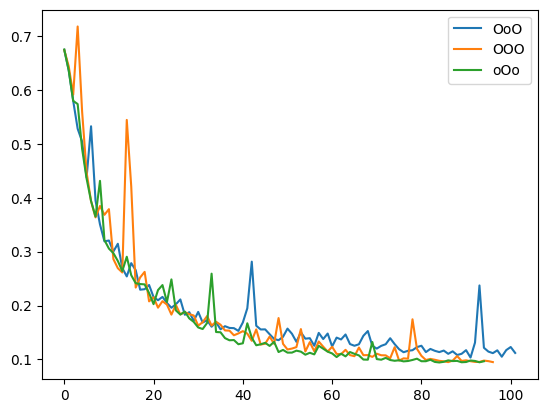

In [36]:
plt.plot(loss_df['OoO'], label = 'OoO')
plt.plot(loss_df['OOO'], label = 'OOO')
plt.plot(loss_df['oOo'], label = 'oOo')
plt.legend()

In [12]:
class ANNModel(nn.Module):
    def __init__(self, hidden_dim_0, hidden_dim_1, hidden_dim_2, hidden_dim_3, input_dim = 1088, output_dim = 1):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_0)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim_0, hidden_dim_1)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(hidden_dim_3, output_dim)

        self.sig1 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        x = self.relu4(x)
        
        x = self.fc5(x)

        x = self.sig1(x)

        return x

In [15]:
# Learning rate finder
error = nn.BCELoss()
learning_rate = 1e-6
hidden_dim_0 = 1024
hidden_dim_1 = 1024
hidden_dim_2 = 1024
hidden_dim_3 = 1024
batch_size = 128
lr_find_range = (-6, 0)

train_index = 48
print(f"TRAIN_INDEX: {train_index}")
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

lr_dict = {}
loss_dict = {}

optimizer_dict = {
#     "Adadelta": torch.optim.Adadelta,
#     "Adagrad": torch.optim.Adagrad,
#     "Adam": torch.optim.Adam,
#     "Adamax": torch.optim.Adamax,
#     "ASGD": torch.optim.ASGD,
#     "NAdam": torch.optim.NAdam,
#     "RAdam": torch.optim.RAdam,
#     "RMSprop": torch.optim.RMSprop,
#     "Rprop": torch.optim.Rprop,
    "SGD": torch.optim.SGD,
#     "SGD-Momentum": torch.optim.SGD,
}

for algo_name, optimizer_class in optimizer_dict.items():
    print(algo_name)
    model = ANNModel(
        hidden_dim_0 = hidden_dim_0, 
        hidden_dim_1 = hidden_dim_1, 
        hidden_dim_2 = hidden_dim_2,
        hidden_dim_3 = hidden_dim_3
    )
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum = 0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    loss_list = []
    lr_list = []
    
    min_loss = float('inf')
    epoch_count = 0

    for lr in tqdm(torch.logspace(lr_find_range[0], lr_find_range[1], steps=100)):
        optimizer.param_groups[0]['lr'] = lr
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        temp_loss = np.mean(temp_loss_list)
        print(f"TRAIN_LOSS: {temp_loss}")
        loss_list.append(temp_loss)
        lr_list.append(lr.item())
    lr_dict[algo_name] = loss_list

TRAIN_INDEX: 48
SGD


100%|██████████| 100/100 [59:35<00:00, 35.75s/it]


In [19]:
df = pd.DataFrame(lr_dict)
df['LR'] = lr_list
df

,SGD,LR
0,0.693719,1.000000e-06
1,0.693718,1.149757e-06
2,0.693718,1.321941e-06
3,0.693717,1.519911e-06
4,0.693716,1.747528e-06
...,...,...
95,0.324632,5.722368e-01
96,0.313433,6.579332e-01
97,0.329689,7.564633e-01
98,0.315016,8.697490e-01


In [21]:
df.to_csv("./model_histories/ANN/lichess_learning_rate_hd_3.csv", index = False)

In [22]:
df = pd.read_csv("./model_histories/ANN/lichess_learning_rate_hd_3.csv")
df

,SGD,LR
0,0.693719,1.000000e-06
1,0.693718,1.149757e-06
2,0.693718,1.321941e-06
3,0.693717,1.519911e-06
4,0.693716,1.747528e-06
...,...,...
95,0.324632,5.722368e-01
96,0.313433,6.579332e-01
97,0.329689,7.564633e-01
98,0.315016,8.697490e-01


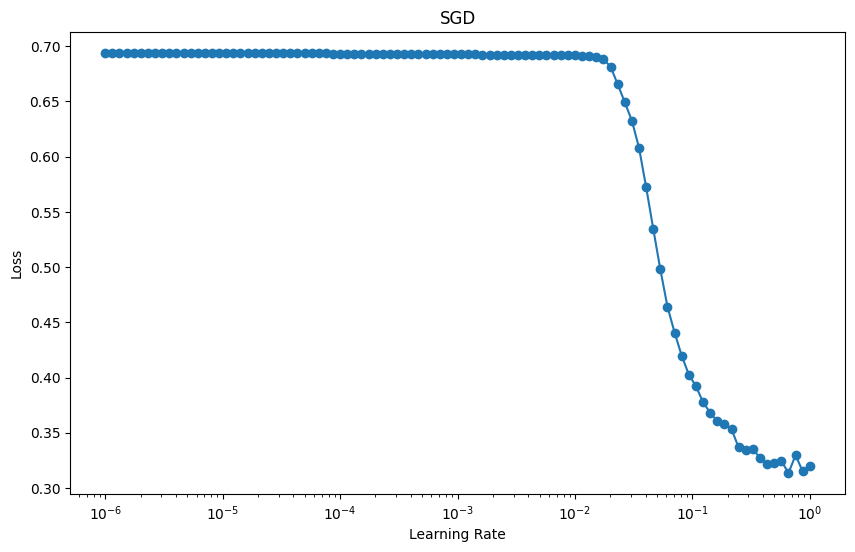

In [23]:
idx = 0
keys = list(df.columns)
plt.figure(figsize=(10, 6))
plt.title(keys[idx])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.plot(df['LR'], df[keys[idx]], marker='o')
plt.show()

In [25]:
error = nn.BCELoss()
batch_size = 128
train_index = 48
print(f"TRAIN_INDEX: {train_index}")
learning_rate = 0.05

train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)

train_loss_dict = {}
val_loss_dict = {}
n_neuron = [(1024, 512, 512, 1024), (1024, 1024, 1024, 1024), (1024, 2048, 2048, 1024)]

for i, hidden_neuron_tuple in enumerate(n_neuron):
    print(hidden_neuron_tuple)
    learning_rate = 0.1
    model = ANNModel(
        hidden_dim_0 = hidden_neuron_tuple[0],
        hidden_dim_1 = hidden_neuron_tuple[1],
        hidden_dim_2 = hidden_neuron_tuple[2],
        hidden_dim_3 = hidden_neuron_tuple[3]
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_loss_list = []
    val_loss_list = []
    min_loss = float('inf')
    epoch_count = 0

    while True:
        temp_loss_list = []
        
        for boards, labels in train_loader:
            train = boards.view(-1, 1088)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            temp_loss_list.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        
        train_loss = np.mean(temp_loss_list)
        train_loss_list.append(train_loss)
        temp_loss_list = []

        for boards, labels in test_loader:
            test = boards.view(-1, 1088)
            outputs = model(test)
            temp_loss_list.append(error(outputs, labels.view(-1, 1)).detach().item())
        
        val_loss = np.mean(temp_loss_list)
        val_loss_list.append(val_loss)

        print(f"TRAIN_LOSS: {round(float(train_loss), 4)}, VAL:_LOSS: {round(float(val_loss), 4)}")

        if val_loss < min_loss:
            min_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1

        if epoch_count >= 10:
            print(f"MIN_TRAIN_LOSS: {min(train_loss_list)}")
            print(f"MIN_VAL_LOSS: {min(val_loss_list)}")
            break
            
    if i == 0:
        structure = "OoO"
    elif i == 1:
        structure = "OOO"
    else:
        structure = "oOo"
        
    train_loss_dict[structure] = train_loss_list
    val_loss_dict[structure] = val_loss_list

TRAIN_INDEX: 48
(1024, 512, 512, 1024)
TRAIN_LOSS: 0.6924, VAL:_LOSS: 0.6911
TRAIN_LOSS: 0.6802, VAL:_LOSS: 0.6742
TRAIN_LOSS: 0.6443, VAL:_LOSS: 0.6368
TRAIN_LOSS: 0.6019, VAL:_LOSS: 0.5541
TRAIN_LOSS: 0.5499, VAL:_LOSS: 0.4992
TRAIN_LOSS: 0.4975, VAL:_LOSS: 0.5284
TRAIN_LOSS: 0.4499, VAL:_LOSS: 0.3895
TRAIN_LOSS: 0.417, VAL:_LOSS: 0.4583
TRAIN_LOSS: 0.3909, VAL:_LOSS: 0.3622
TRAIN_LOSS: 0.3612, VAL:_LOSS: 0.6961
TRAIN_LOSS: 0.3373, VAL:_LOSS: 0.3301
TRAIN_LOSS: 0.3159, VAL:_LOSS: 0.2861
TRAIN_LOSS: 0.302, VAL:_LOSS: 0.2828
TRAIN_LOSS: 0.2821, VAL:_LOSS: 0.2632
TRAIN_LOSS: 0.2733, VAL:_LOSS: 0.2643
TRAIN_LOSS: 0.2605, VAL:_LOSS: 0.2412
TRAIN_LOSS: 0.242, VAL:_LOSS: 0.2605
TRAIN_LOSS: 0.2317, VAL:_LOSS: 0.2403
TRAIN_LOSS: 0.2244, VAL:_LOSS: 0.2269
TRAIN_LOSS: 0.2082, VAL:_LOSS: 0.2833
TRAIN_LOSS: 0.2017, VAL:_LOSS: 0.2203
TRAIN_LOSS: 0.1923, VAL:_LOSS: 0.2197
TRAIN_LOSS: 0.1896, VAL:_LOSS: 0.2194
TRAIN_LOSS: 0.1749, VAL:_LOSS: 0.1949
TRAIN_LOSS: 0.1731, VAL:_LOSS: 0.2047
TRAIN_LOSS: 0.

KeyboardInterrupt: 

In [ ]:
val_loss_ranking_list = [np.mean(val_loss_dict[x][-10:]) for x in val_loss_dict]
val_loss_ranking_dict = dict(zip(list(val_loss_dict.keys()), val_loss_ranking_list))
val_loss_ranking_dict = sorted(val_loss_ranking_dict.items(), key=lambda x: x[1])
val_loss_ranking_dict

In [ ]:
max_len = max(len(lst) for lst in val_loss_dict.values())
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in val_loss_dict.items()}
loss_df = pd.DataFrame(loss_filled_results)
loss_df.to_csv("./model_histories/ANN/structure_selector_val_loss_hd_4.csv", index = False)
loss_df

In [ ]:
plt.plot(loss_df['OoO'], label = 'OoO')
plt.plot(loss_df['OOO'], label = 'OOO')
plt.plot(loss_df['oOo'], label = 'oOo')
plt.legend()

In [23]:
def fen_to_bitboard(fen):
    row, column = 0, 0
    bitboard = np.zeros((17, 8, 8))
    for c in fen:
        if c == " ":
            break
        elif c == "P":
            bitboard[0][row][column] = 1
            column += 1
        elif c == "p":
            bitboard[6][row][column] = 1
            column += 1
        elif c == "R":
            bitboard[1][row][column] = 1
            column += 1
        elif c == "r":
            bitboard[7][row][column] = 1
            column += 1
        elif c == "N":
            bitboard[2][row][column] = 1
            column += 1
        elif c == "n":
            bitboard[8][row][column] = 1
            column += 1
        elif c == "B":
            bitboard[3][row][column] = 1
            column += 1
        elif c == "b":
            bitboard[9][row][column] = 1
            column += 1
        elif c == "Q":
            bitboard[4][row][column] = 1
            column += 1
        elif c == "q":
            bitboard[10][row][column] = 1
            column += 1
        elif c == "K":
            bitboard[5][row][column] = 1
            column += 1
        elif c == "k":
            bitboard[11][row][column] = 1
            column += 1
        elif c == "/":
            row += 1
            column = 0
        elif c in "123456789":
            column += int(c)
    
    castle_rights = fen.split(" ")[2]
    for i in range(8):
        for j in range(8):
            bitboard[12][i][j] = int("K" in castle_rights)
    for i in range(8):
        for j in range(8):
            bitboard[13][i][j] = int("Q" in castle_rights)
    for i in range(8):
        for j in range(8):
            bitboard[14][i][j] = int("k" in castle_rights)
    for i in range(8):
        for j in range(8):
            bitboard[15][i][j] = int("q" in castle_rights)
    
    turn = fen.split(" ")[1]
    for i in range(8):
        for j in range(8):
            bitboard[16][i][j] = int(turn == "b")
        
    return bitboard

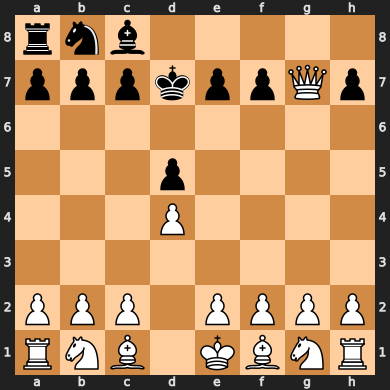

In [28]:
board = chess.Board("rnb5/pppkppQp/8/3p4/3P4/8/PPP1PPPP/RNB1KBNR b KQ - 0 8")
board

In [24]:
test_fen = "rnb5/pppkppQp/8/3p4/3P4/8/PPP1PPPP/RNB1KBNR b KQ - 0 8"
test_board = torch.tensor(fen_to_bitboard(test_fen).flatten(), dtype=torch.float32)
test_board

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [25]:
model(test_board)

tensor([0.8234], grad_fn=<SigmoidBackward0>)